In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
from pyquery import PyQuery as pq
import demjson
import re
import importlib
import parsing
import graphs
import processamento_dados

from parsing import *
from graphs import *
from processamento_dados import *

importlib.reload(parsing)
importlib.reload(graphs)
importlib.reload(processamento_dados)

<module 'processamento_dados' from 'c:\\Users\\filip\\OneDrive - Universidade do Minho\\LEI\\benchmarks\\processamento_dados.py'>

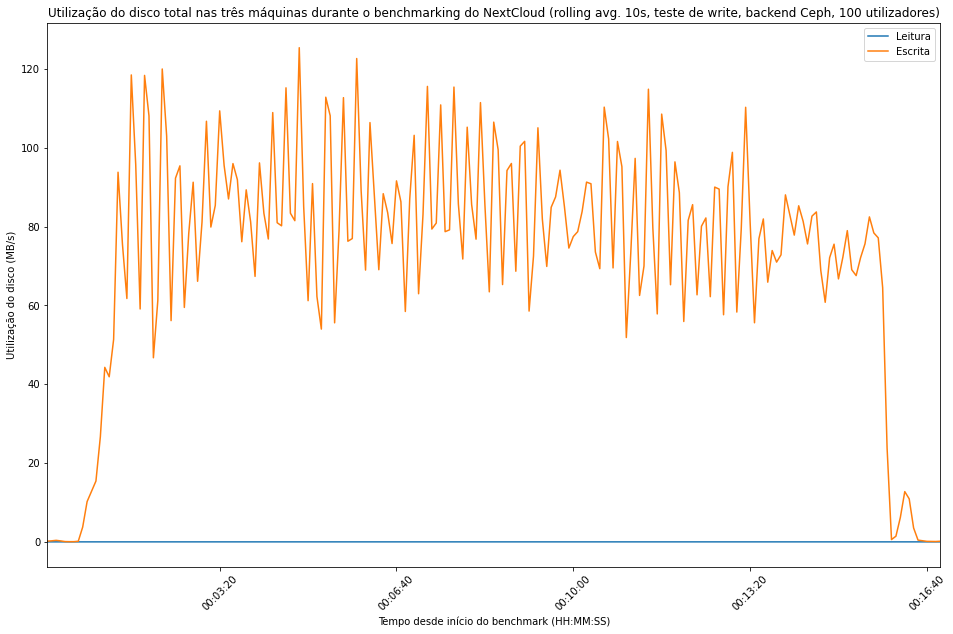

In [63]:
make_disk_ceph_graph('NextCloud', 'staticWrite', 100, False)

In [ ]:
def make_graphs_for_scenario(app, storage, test_name, test_size):
    make_system_graphs(app, storage, test_name, test_size)
    # Faltam gráficos do Disco:
    #  No caso do NFS, é apenas cloud108_..._io.csv
    #  No caso do Ceph, todas as máquinas têm um ..._io.csv, caso em que queremos a soma total da utilização do disco

    # Falta gráficos do locust:
    # req/s, fails/s
    # response times
    make_locust_graphs(app, storage, test_name, test_size)

In [57]:
df = read_dfs_io('NextCloud', 'Ceph', 'staticWrite', 100)
df.duplicated()
    # .pivot(index = 'time', columns = 'machine', values = ['read_kb'])['read_kb']
# read_series

machine   time           
cloud106  0 days 00:00:00    False
          0 days 00:00:05    False
          0 days 00:00:10    False
          0 days 00:00:15    False
          0 days 00:00:20    False
                             ...  
          0 days 00:16:35     True
          0 days 00:16:40     True
          0 days 00:16:45     True
          0 days 00:16:50     True
          0 days 00:16:55     True
Length: 408, dtype: bool

In [20]:
read_series = df.reset_index() \
        .pivot(index = 'time', columns = 'machine', values = ['read_kb'])['read_kb'] \
        .rolling(2).mean() \
        .dropna()

In [21]:
read_series

machine,cloud108
time,
0 days 00:00:05,0.0
0 days 00:00:10,0.0
0 days 00:00:15,0.0
0 days 00:00:20,0.0
0 days 00:00:25,0.0
...,...
0 days 00:16:35,0.0
0 days 00:16:40,0.0
0 days 00:16:45,0.0
